In [1]:
pip install pandas matplotlib scikit-learn tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



In [21]:
# Load data
df = pd.read_csv(r"C:\Users\naras\Documents\Big Data Analytics\BDA Project Solo\Datasets\InternationalAirlineData_Cleaned.csv")

# Filter Delta Airlines
delta_df = df[df["carrier_full_name"] == "Delta Air Lines"]

# Convert date
delta_df.loc[:, "data_dte"] = pd.to_datetime(delta_df["data_dte"], errors='coerce')


# Rebuild delta_monthly with date included
delta_monthly = (
    delta_df.groupby(pd.Grouper(key="data_dte", freq="ME"))["Total"]
    .sum()
    .reset_index()
    .rename(columns={"data_dte": "Date", "Total": "Total_Traffic"})
)

# Confirm fix
print(delta_monthly.columns)



C:\Users\naras\AppData\Roaming\Python\Python312\site-packages\pandas\core\groupby\grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)


Index(['Date', 'Total_Traffic'], dtype='object')


In [28]:
# Scale the traffic data directly (no need to set_index again)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(delta_monthly)

# Optional: put back in DataFrame for reference
scaled_df = pd.DataFrame(scaled_data, index=delta_monthly.index, columns=["Total_Traffic"])


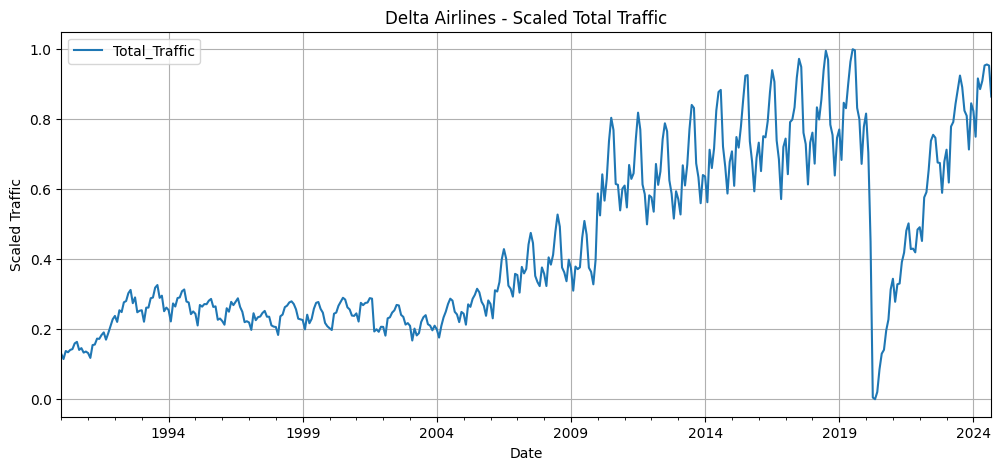

In [30]:
import matplotlib.pyplot as plt

scaled_df.plot(figsize=(12, 5), title="Delta Airlines - Scaled Total Traffic")
plt.ylabel("Scaled Traffic")
plt.xlabel("Date")
plt.grid(True)
plt.show()



In [33]:
# Convert to NumPy array
data = scaled_df.values

# Define a function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Use 12 months of history to predict next month
seq_length = 12
X, y = create_sequences(data, seq_length)

# Reshape for LSTM: [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [35]:
# Define the model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))

# Compile
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X, y, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2202
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0839
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0085
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 
Epoch 16/20
13/1

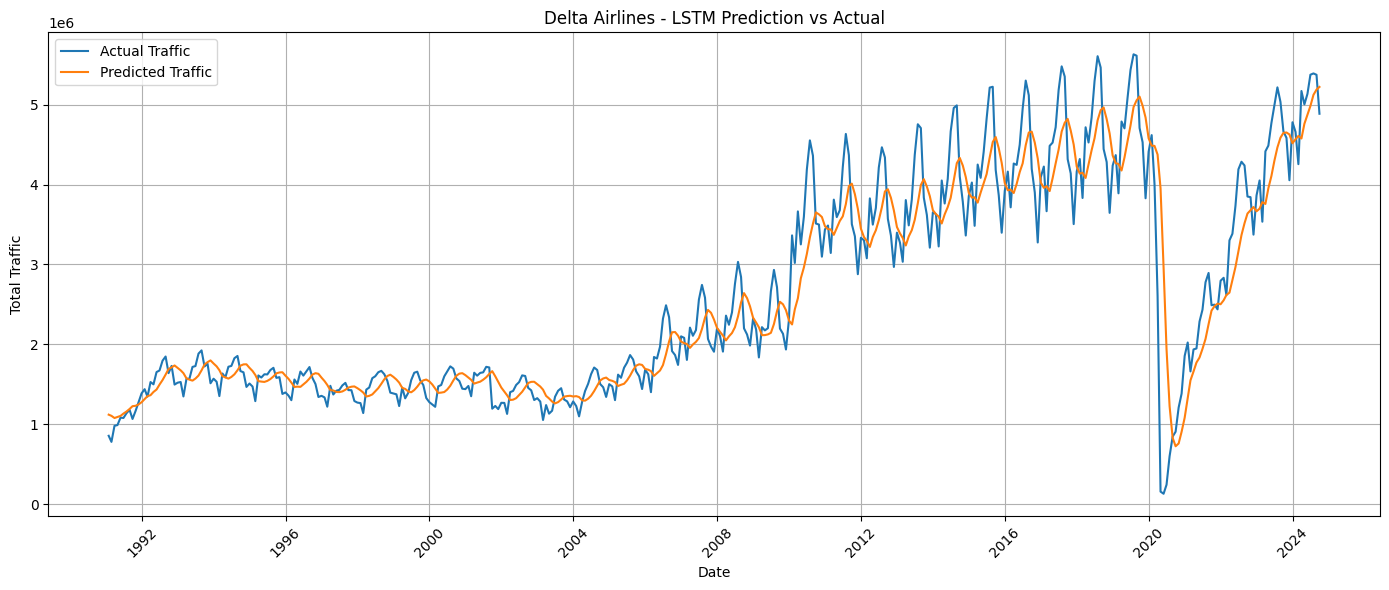

In [37]:
# Re-align dates: skip the first 12 months (used for sequences)
prediction_dates = delta_monthly.index[seq_length:]

# Plot with actual dates on x-axis
plt.figure(figsize=(14, 6))
plt.plot(prediction_dates, actual_traffic, label="Actual Traffic")
plt.plot(prediction_dates, predicted_traffic, label="Predicted Traffic")
plt.title("Delta Airlines - LSTM Prediction vs Actual")
plt.xlabel("Date")
plt.ylabel("Total Traffic")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [38]:
# Start from the last 12 months of scaled data
last_sequence = scaled_data[-seq_length:]  # shape: (12, 1)
forecast_input = last_sequence.reshape(1, seq_length, 1)

# How many months into the future to forecast
n_steps = 12
future_predictions = []

# Forecast step-by-step
for _ in range(n_steps):
    next_pred = model.predict(forecast_input)[0]
    future_predictions.append(next_pred)

    # Slide the window
    forecast_input = np.append(forecast_input[:, 1:, :], [[next_pred]], axis=1)

# Inverse transform to get real traffic numbers
future_traffic = scaler.inverse_transform(future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [40]:
# Create datetime index for forecast
last_date = delta_monthly.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_steps, freq='ME')


# Create forecast DataFrame
forecast_df = pd.DataFrame(future_traffic, index=future_dates, columns=["Forecasted_Traffic"])


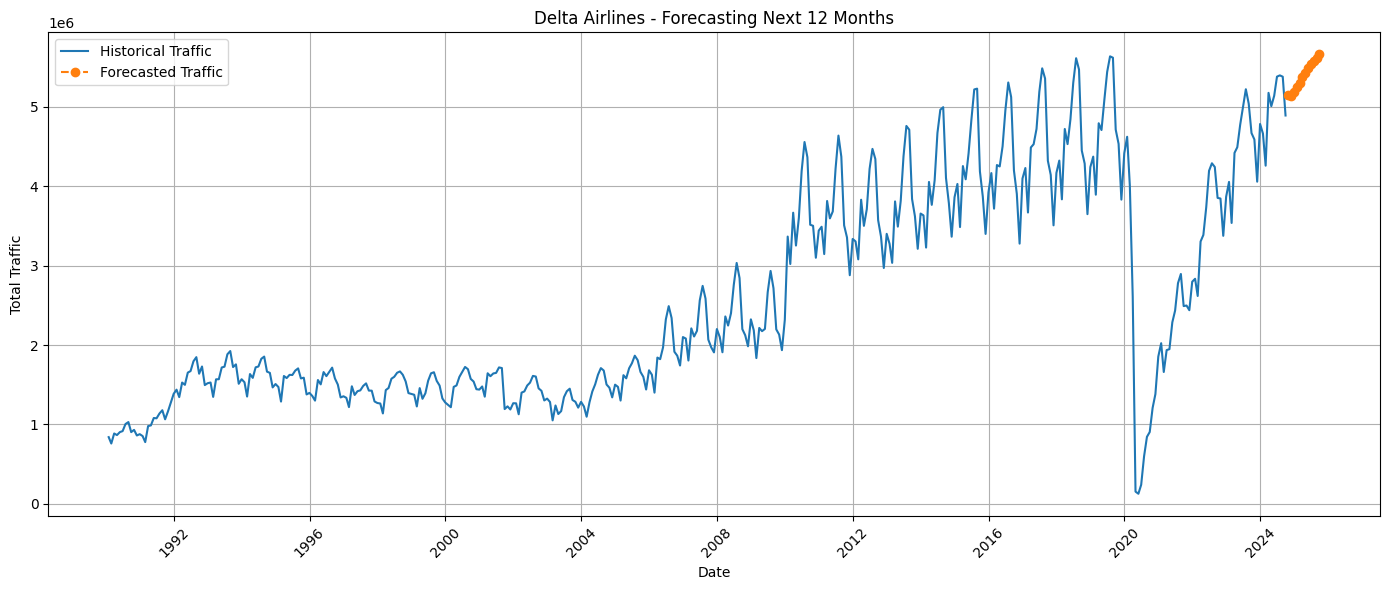

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(delta_monthly.index, delta_monthly["Total_Traffic"], label="Historical Traffic")
plt.plot(forecast_df.index, forecast_df["Forecasted_Traffic"], label="Forecasted Traffic", linestyle='--', marker='o')
plt.title("Delta Airlines - Forecasting Next 12 Months")
plt.xlabel("Date")
plt.ylabel("Total Traffic")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [42]:
forecast_df.to_csv("delta_airlines_forecast.csv")
